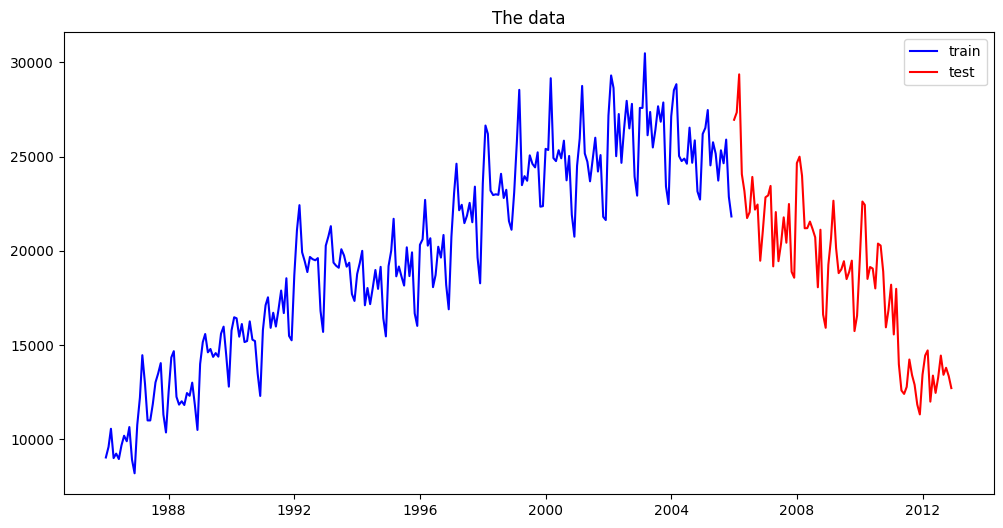

In [ ]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
import pandas as pd
import statsmodels.api as sm


df = pd.read_csv('/content/CATFISH.csv')
df['Date'] = pd.to_datetime(df.Date)
df.set_index('Date', inplace = True)

train = df[:240]
test = df[240:]

fig = plt.figure(figsize = (12,6))
plt.plot(train, color = 'blue', label = "train")
plt.plot(test, color = 'red', label = "test")
plt.title("The data")
plt.legend()
plt.show()

In [ ]:
rmse_dict = {}
forcast_dict = {}
def CompinedModels(data_original, Arima_parameters, xGboost_parameters):
  """
  parameters :
  data: Pandas dataframe of a single series with index of type DateTime
  Arima_parameters: Tuple -or list like- of shape (3) with P,Q,D
  xGboost_parameters: a list of 2 items
    - the fist is a dictionary with the parameters
    - the second is the number of iterations
  """
  global rmse_dict
  global forcast_dict

  # part 1 | ARIMA
  data_A = data_original.copy()
  # split the data
  train = data_A[:260]
  test = data_A[260:]

  # build the model
  model = ARIMA(train, order = Arima_parameters)
  model_fit = model.fit()


  # evaluate the ARIMA model in the test set
  forecast_df = model_fit.predict(start = 261, end = df.shape[0] )
  forecast = np.array(forecast_df)
  forcast_dict['ARIMA'] = forecast
  rmse = sqrt(mean_squared_error(test, forecast))
  rmse_dict['ARIMA'] = rmse


  # plot the result
  fig = plt.figure(figsize = (12,6))
  plt.plot(test, color = 'orange', label = "future real data")
  '''
  plt.fill_between(
    test.index,
    conf[:,0],
    conf[:,1],
    forecast['Upper'],
    alpha=0.7,
    color='gray',
    label='Confidence Area'
    )
  '''
  plt.plot(forecast_df, color = 'green', label = "future predicted data")
  plt.title("ARIMA RESULTS")
  plt.legend()
  plt.show()
  print(f'model AIC : {model_fit.aic}')
  print(f'model BIC : {model_fit.bic}')

  # part 2 | xGboost
  data = data_original.copy()
  # Create multible features (lagged variables)
  lags = 10
  for i in range(1, lags + 1):
      data[f'lag_{i}'] = data['Total'].shift(i)

  # Prepare the data for XGBoost
  # split the data into (train, validate, test)

  X_train = data[:220].drop(['Total'], axis=1)
  y_train = data[:220]['Total']

  X_val = data[220:260].drop(['Total'], axis=1)
  y_val = data[220:260]['Total']

  X_test = data[260:].drop(['Total'], axis=1)
  y_test = data[260:]['Total']

  # put the data into a form of a matrix that fits into xGBoost
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dval = xgb.DMatrix(X_val, label=y_val)
  dtest = xgb.DMatrix(X_test, label=y_test)

  params = xGboost_parameters[0]
  num_rounds = xGboost_parameters[1]

  model = xgb.train(
    params=params,
    dtrain = dtrain,
    num_boost_round=num_rounds,
    early_stopping_rounds=10,
    evals=[(dval, 'validation')]
  )

  # Evaluate the XGBoost model on the test set
  y_pred = model.predict(dtest)
  forcast_dict['XGBOOST'] = y_pred
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  rmse_dict['XGBOOST'] = rmse

  # plot the results
  fig = plt.figure(figsize = (12,6))
  plt.plot(data[260:].index,y_pred, color = 'green', label = 'xGBoost')
  plt.plot(data[260:].index,y_test.values, color = 'orange', label = 'True values')
  plt.title("XGBOOST RESULTS")
  plt.legend()
  plt.plot()

  #importance of features in XGBOOST
  importance = model.get_score(importance_type='gain')
  importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
  fi = pd.DataFrame(importance, columns=['feature', 'importance'])
  fi.sort_values('importance').plot(kind='barh', x='feature', y='importance', title='Feature Importance')
  plt.show()


  # part 3 : the average forcast
  # combine the predictions using a weighted average
  weights = [rmse_dict['ARIMA'] / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST']), rmse_dict['XGBOOST'] / (rmse_dict['ARIMA'] + rmse_dict['XGBOOST'])]
  combined_pred = np.average([forcast_dict['ARIMA'], forcast_dict['XGBOOST']], axis=0, weights=weights)
  combined_pred = pd.DataFrame(combined_pred, index = test.index)
  rmse = sqrt(mean_squared_error(test.values, combined_pred))
  rmse_dict['AVERAGE RESULTS'] = rmse


  # plot the result
  fig = plt.figure(figsize = (12,6))
  plt.plot(test, color = 'orange', label = "future real data")
  plt.plot(combined_pred, color = 'green', label = "future predicted data")
  plt.title("AVERAGE RESULT")
  plt.legend()
  plt.show()

  print(rmse_dict)

In [ ]:
def bestParametersXGBOOST(df):
  '''
  input : df of type pandas.DataFrame
  output : a dictionary of the best params
  we can use a function to return the best parameters for XGBOOST
  based on the data we use

  '''
  data = df.copy()
  lags = 10
  for i in range(1, lags + 1):
      data[f'lag_{i}'] = data['Total'].shift(i)
  model = xgb.XGBRegressor()
  X_train = data[:220].drop(['Total'], axis=1)
  y_train = data[:220]['Total']
  cv = TimeSeriesSplit(n_splits=5)
  param_grid = {
      'max_depth': [3, 4, 5],
      'learning_rate': [0.05, 0.1, 0.15],
      'n_estimators': [50, 100, 150],
      'subsample': [0.6, 0.8, 1],
      'colsample_bytree': [0.6, 0.8, 1],
      'reg_alpha': [0.001, 0.005, 0.01]
  }
  grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)
  grid.fit(X_train, y_train)
  return grid.best_params_


In [ ]:
bestParametersXGBOOST(df)

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 100,
 'reg_alpha': 0.001,
 'subsample': 0.6}

In [ ]:
Arima_parameters = (20,1,19) # we statistically calculated it in the ARIMA notebook
xGboost_parameters = [{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 100,
 'reg_alpha': 0.001,
 'subsample': 0.6} ,100]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

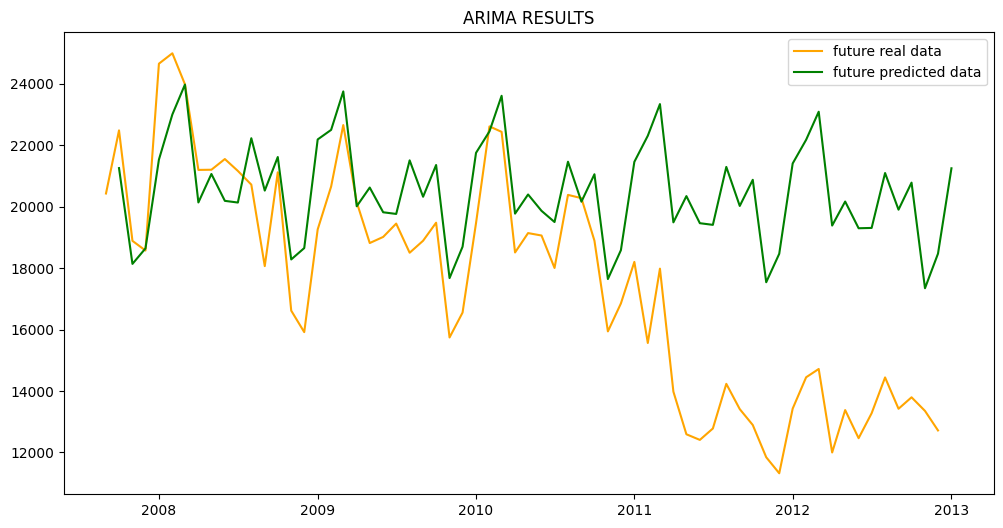

model AIC : 4332.101825097625
model BIC : 4474.374947565607
[23:20:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	validation-rmse:21595.10148
[1]	validation-rmse:19502.57986
[2]	validation-rmse:17681.46095
[3]	validation-rmse:15966.41143
[4]	validation-rmse:14413.76759
[5]	validation-rmse:12892.61755
[6]	validation-rmse:11680.44974
[7]	validation-rmse:10518.30474
[8]	validation-rmse:9457.96772
[9]	validation-rmse:8439.92714
[10]	validation-rmse:7619.13056
[11]	validation-rmse:6788.86136
[12]	validation-rmse:6141.13710
[13]	validation-rmse:5509.90975
[14]	validation-rmse:4919.48414
[15]	validation-rmse:4419.62070
[16]	validation-rmse:4052.97028
[17]	validation-rmse:3670.98236
[18]	validation-rmse:3344.29655
[19]	validation-rmse:3031.29215
[20]	validation-rmse:2755.17004
[21]	validation-rmse:2552.10713
[22]	validation-rmse:2378.10555
[23]	validation-rmse:2230.09184
[24]	validation-rmse:2089.83310
[25]	validation-rmse:1967.16555
[26]	validation-rmse

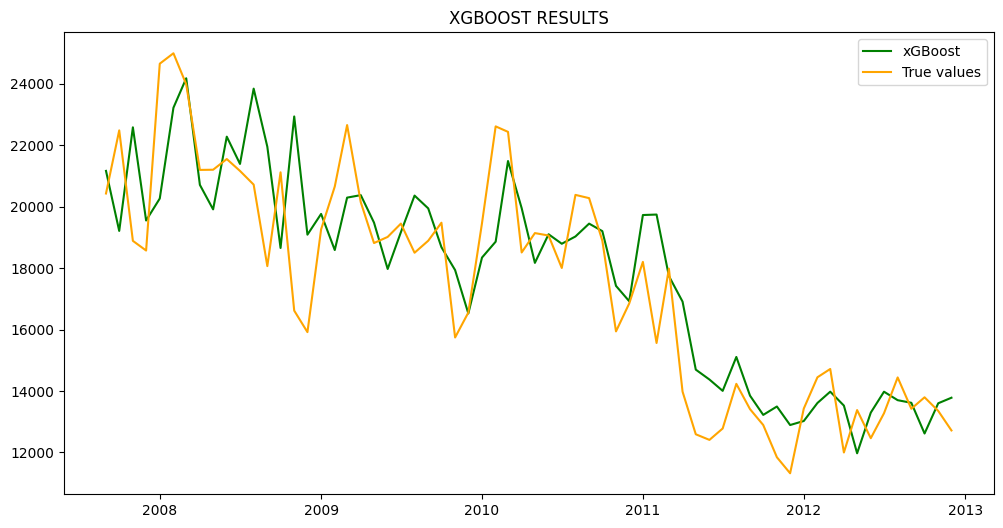

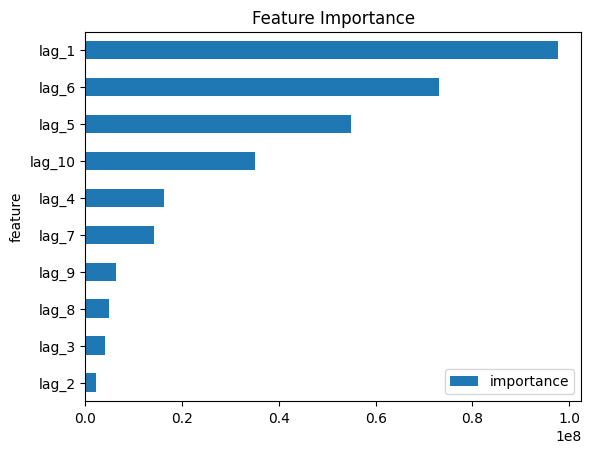

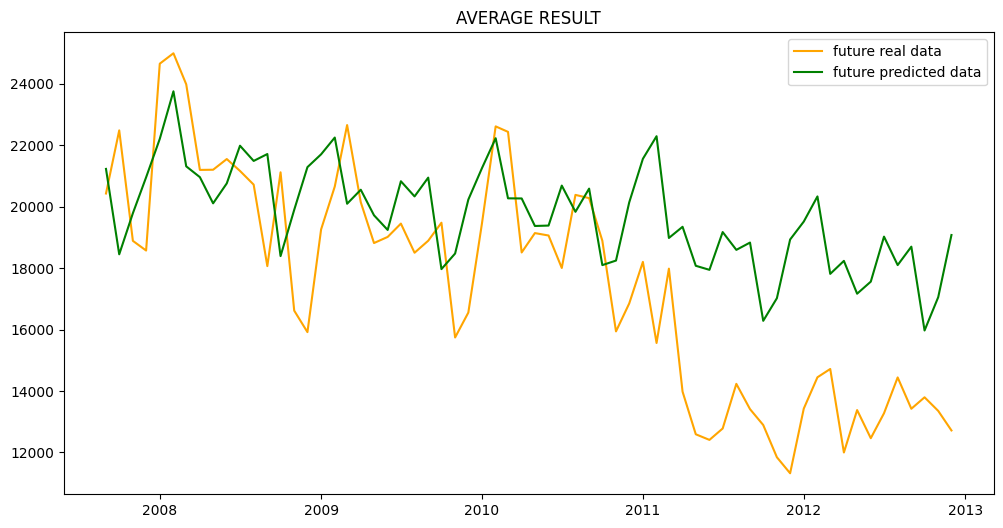

{'ARIMA': 4652.120563208361, 'XGBOOST': 1907.849518684049, 'AVERAGE RESULTS': 3563.9280759131}


In [ ]:
CompinedModels(df,Arima_parameters, xGboost_parameters)